<h1> LA Metro Transit Consolidation 2.0

**By**: Andrew Williams

**Partner:** Ben Brassette

**Description:** The purpose of this notebook to consolidate LA metro bus and rail lines. Most of this notebook will involve diving into diffenent datasets and ensuring it can be used with other datasets in the future. No in-depth analysis of the data yet. There is no major analysis here or use of functions or loops. Though in hindsight, I think I could have used created some loops here, but just wasn't hinking straight. 

Bus frequency is being added becasue I think might inform our analysis of what areas need more frequent bus use, which in turn helps us understand how LA public transit is being used and why workers use certain routes. 

# Importing Libraries and Datasets

Importing libraries for gpd, plotting, and basepamps.

In [1]:
import urllib.request, json 
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

In [2]:
# halfway through mapping and I realized I need more context
import contextily as ctx

Import was successful.

Importing datasets: rail, bus, and bus frequency.

In [3]:
rail_stops = gpd.read_file('Data/RailStations0715/Stations_All_0715.shp')

bus_freq = gpd.read_file('Data/means2work_freq/Existing_Bus_System.shp')

Shape files are ready for exploration now. 

# Bus Frequency 

This is new bus data. I imagine it will mirror much of what I had before from just the LA Metro bus lines, with the addition of frequency. I'm going to explore it a little but and see what I have to work with.

In [4]:
type(bus_freq)

geopandas.geodataframe.GeoDataFrame

In [5]:
bus_freq.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   rte         158 non-null    float64 
 1   rte2        158 non-null    object  
 2   rteDesc     158 non-null    object  
 3   rteNum      158 non-null    object  
 4   tier        158 non-null    object  
 5   ampk_1      158 non-null    float64 
 6   midday_1    158 non-null    float64 
 7   pmpk_1      158 non-null    float64 
 8   seven_9_10  158 non-null    float64 
 9   ten_12_13   158 non-null    float64 
 10  owl_1       158 non-null    float64 
 11  sa68        158 non-null    float64 
 12  sa111       158 non-null    float64 
 13  sa35        158 non-null    float64 
 14  sa79        158 non-null    float64 
 15  sa1012      158 non-null    float64 
 16  sa24        158 non-null    float64 
 17  su68        158 non-null    float64 
 18  su111       158 non-null    float64 
 19  

Lots of columns! I can vaugely picture what I this will say in terms of frequency.

In [6]:
bus_freq.shape

(158, 24)

In [7]:
bus_freq.head(3)

,rte,rte2,rteDesc,rteNum,tier,ampk_1,midday_1,pmpk_1,seven_9_10,ten_12_13,...,sa79,sa1012,sa24,su68,su111,su35,su79,su1012,su24,geometry
0,2.0,2,Sunset Blvd,2,Local,15.0,15.0,15.0,20.0,30.0,...,20.0,30.0,60.0,20.0,20.0,20.0,30.0,30.0,60.0,"MULTILINESTRING ((-13165102.619 4033296.175, -..."
1,4.0,4,Santa Monica Blvd,4,Local,10.0,15.0,10.0,20.0,20.0,...,20.0,20.0,30.0,20.0,15.0,15.0,25.0,25.0,25.0,"MULTILINESTRING ((-13190607.696 4031215.079, -..."
2,10.0,10,Melrose/San Pedro,10/48,Local,7.5,20.0,10.0,30.0,60.0,...,18.0,60.0,60.0,30.0,20.0,20.0,40.0,60.0,60.0,"MULTILINESTRING ((-13165702.631 4019568.409, -..."


In [8]:
bus_freq.tail(3)

,rte,rte2,rteDesc,rteNum,tier,ampk_1,midday_1,pmpk_1,seven_9_10,ten_12_13,...,sa79,sa1012,sa24,su68,su111,su35,su79,su1012,su24,geometry
155,686.0,686,Altadena - Pasadena,686,Shuttles,40.0,40.0,40.0,50.0,0.0,...,60.0,0.0,0.0,30.0,60.0,60.0,60.0,0.0,0.0,"MULTILINESTRING ((-13152272.937 4048395.170, -..."
156,950.0,950,Silver Line,950,Busway,5.0,30.0,5.0,30.0,20.0,...,40.0,20.0,60.0,30.0,30.0,30.0,40.0,20.0,60.0,"MULTILINESTRING ((-13167756.587 3992199.021, -..."
157,292.0,292,Glenoaks/Brand/Glendale,292,Local,25.0,25.0,25.0,35.0,60.0,...,60.0,60.0,60.0,40.0,40.0,40.0,60.0,60.0,60.0,"MULTILINESTRING ((-13164275.738 4034236.916, -..."


In terms of the the columns, I believe I'm seeing the number of times a bus is being in use during a particular period.

I would like to see what routes/bus-systems/tiers are available in this dataset.

In [9]:
bus_freq['tier'].value_counts()

Local       105
Rapid        20
Shuttles     11
Limited      11
Express       8
Busway        3
Name: tier, dtype: int64

The biggest differnce I see between my previous Metro bus data was that the local lines were subdivided into two categories: CBD and Non-CBD. This one large category seems unruly, but if need be, I can query and sub divide it further. 

Next step is to create to sub-categories which will be easier to call than having an extroadinarly long syntaxt (though I should practice those as well)>

## Local Bus Freq

Will define and quickly map data to see results.

Pulling subset of data- local routes

In [10]:
local_f = bus_freq[bus_freq.tier == 'Local']
local_f.sample(3)

,rte,rte2,rteDesc,rteNum,tier,ampk_1,midday_1,pmpk_1,seven_9_10,ten_12_13,...,sa79,sa1012,sa24,su68,su111,su35,su79,su1012,su24,geometry
10,35.0,35,Washington/Jefferson,35/38,Local,10.0,15.0,12.0,20.0,60.0,...,40.0,60.0,0.0,40.0,20.0,20.0,40.0,60.0,0.0,"MULTILINESTRING ((-13166450.587 4031524.520, -..."
94,267.0,267,Altadena - El Monte,267,Local,30.0,30.0,30.0,25.0,0.0,...,0.0,0.0,0.0,60.0,60.0,60.0,0.0,0.0,0.0,"MULTILINESTRING ((-13140648.176 4038476.119, -..."
43,130.0,130,Artesia Blvd,130,Local,25.0,50.0,30.0,55.0,0.0,...,60.0,0.0,0.0,60.0,60.0,60.0,60.0,0.0,0.0,"MULTILINESTRING ((-13178894.993 4007098.752, -..."


Pulling subset of data- Rapid routes

In [11]:
local_f = bus_freq[bus_freq.tier == 'Local']
local_f.sample(3)

,rte,rte2,rteDesc,rteNum,tier,ampk_1,midday_1,pmpk_1,seven_9_10,ten_12_13,...,sa79,sa1012,sa24,su68,su111,su35,su79,su1012,su24,geometry
69,210.0,210,Crenshaw Blvd,210,Local,15.0,20.0,15.0,30.0,60.0,...,20.0,60.0,0.0,25.0,15.0,15.0,30.0,60.0,0.0,"MULTILINESTRING ((-13173676.892 4011737.885, -..."
78,233.0,233,Van Nuys Blvd,233,Local,12.0,15.0,15.0,30.0,40.0,...,20.0,40.0,60.0,20.0,20.0,20.0,30.0,40.0,60.0,"MULTILINESTRING ((-13185647.745 4049084.269, -..."
37,117.0,117,Imperial/Century,117,Local,15.0,20.0,15.0,35.0,60.0,...,50.0,60.0,0.0,30.0,30.0,30.0,35.0,60.0,0.0,"MULTILINESTRING ((-13152038.164 4018259.282, -..."


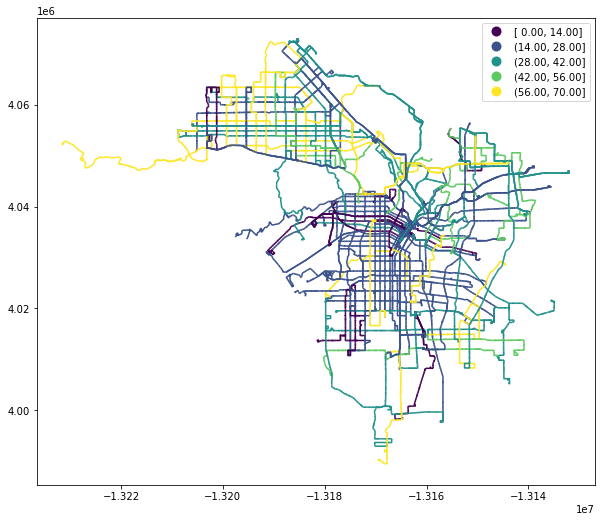

In [12]:
local_f.plot(
            figsize=(10,10),   
            column = 'midday_1',  
            legend = True,             
            scheme = 'equal_interval',)   

This is great! Much better than my previous bus maps. I'm going to cycle through and finish defining these subcategoires. Next steps would include a query into which routes are the heavist used and then overlay that with transit census tracts. 

## Rapid Freq

Pulling subset of data- Rapid routes

In [13]:
rapid_f = bus_freq[bus_freq.tier == 'Rapid']
rapid_f.sample(3)

,rte,rte2,rteDesc,rteNum,tier,ampk_1,midday_1,pmpk_1,seven_9_10,ten_12_13,...,sa79,sa1012,sa24,su68,su111,su35,su79,su1012,su24,geometry
130,780.0,780,Hollywood - Pasadena Rapid,780,Rapid,10.0,20.0,12.0,60.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTILINESTRING ((-13176817.549 4033455.087, -..."
127,760.0,760,Pacific Blvd Rapid,760,Rapid,12.0,20.0,15.0,30.0,0.0,...,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTILINESTRING ((-13159008.211 4018565.018, -..."
124,751.0,751,Daly/Soto Rapid,751,Rapid,15.0,20.0,15.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTILINESTRING ((-13160521.600 4023947.789, -..."


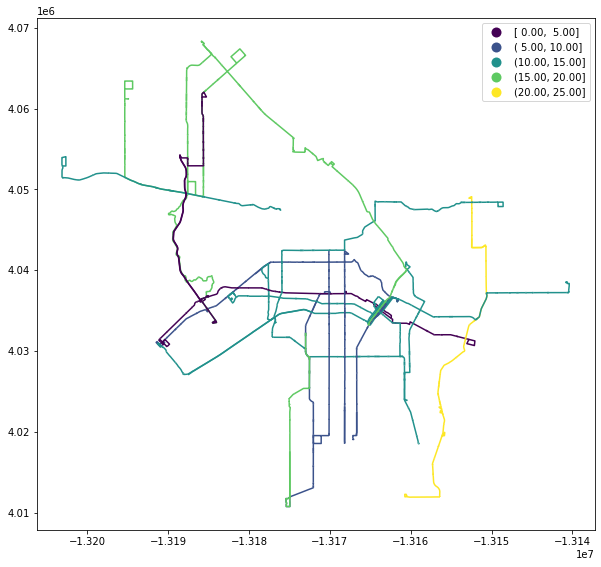

In [14]:
rapid_f.plot(
            figsize=(10,10),   
            column = 'pmpk_1',  
            legend = True,             
            scheme = 'equal_interval',)   

Also revealing. I'm curious what the line on the far east of the map is and what its connections are to job centers, other lines. 

## Limited Frew

Pulling subset of data- Limited routes

In [15]:
limited_f = bus_freq[bus_freq.tier == 'Limited']
limited_f.sample(3)

,rte,rte2,rteDesc,rteNum,tier,ampk_1,midday_1,pmpk_1,seven_9_10,ten_12_13,...,sa79,sa1012,sa24,su68,su111,su35,su79,su1012,su24,geometry
144,312.0,312,La Brea Ave,312,Limited,10.0,25.0,12.0,20.0,30.0,...,20.0,25.0,60.0,35.0,20.0,20.0,20.0,25.0,60.0,"MULTILINESTRING ((-13173983.243 4020509.361, -..."
145,316.0,316,3rd St,316,Limited,10.0,10.0,20.0,15.0,30.0,...,10.0,20.0,0.0,12.0,8.0,8.0,20.0,20.0,0.0,"MULTILINESTRING ((-13178905.457 4032744.770, -..."
149,355.0,355,Adams/Compton,355,Limited,15.0,20.0,15.0,60.0,60.0,...,30.0,60.0,60.0,30.0,23.0,23.0,60.0,60.0,60.0,"MULTILINESTRING ((-13163095.863 4018571.592, -..."


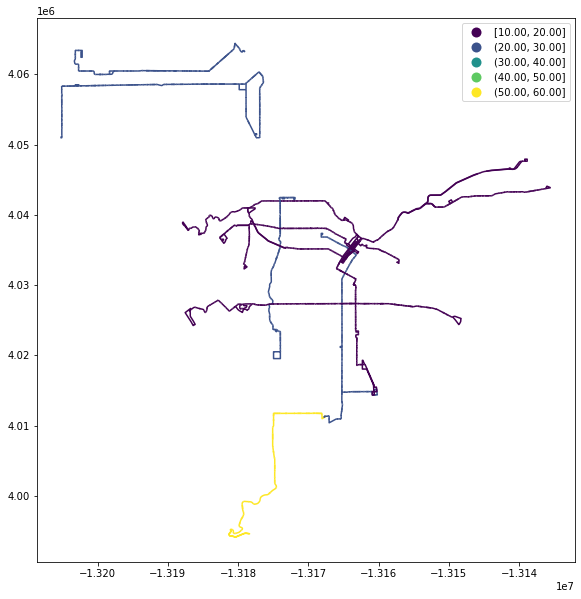

In [16]:
limited_f.plot(
            figsize=(10,10),   
            column = 'midday_1',  
            legend = True,             
            scheme = 'equal_interval',)   

## Shuttle Freq

Pulling subset of data-- for Shuttles

In [17]:
shuttle_f = bus_freq[bus_freq.tier == 'Shuttles']
shuttle_f.sample(3)

,rte,rte2,rteDesc,rteNum,tier,ampk_1,midday_1,pmpk_1,seven_9_10,ten_12_13,...,sa79,sa1012,sa24,su68,su111,su35,su79,su1012,su24,geometry
110,665.0,665,Cal State LA - East Los Angeles,665,Shuttles,40.0,40.0,50.0,40.0,0.0,...,0.0,0.0,0.0,0.0,60.0,60.0,0.0,0.0,0.0,"MULTILINESTRING ((-13158745.163 4031319.837, -..."
111,685.0,685,Glassell Park - Glendale,685,Shuttles,30.0,30.0,30.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTILINESTRING ((-13162190.168 4042866.534, -..."
109,625.0,625,LAX - Hawthorne,625,Shuttles,20.0,0.0,20.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTILINESTRING ((-13176891.019 4019121.105, -..."


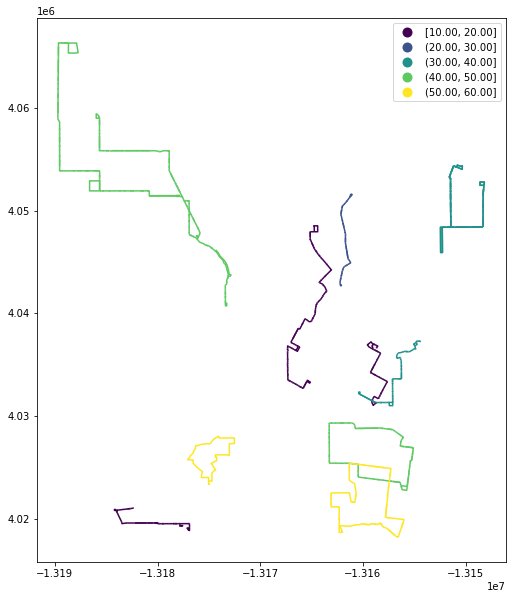

In [18]:
shuttle_f.plot(
            figsize=(10,10),   
            column = 'ampk_1',  
            legend = True,             
            scheme = 'equal_interval',)   

## Exp Freq

Pulling subset of data- Exp routes

In [19]:
exp_f = bus_freq[bus_freq.tier == 'Express']
exp_f.sample(3)

,rte,rte2,rteDesc,rteNum,tier,ampk_1,midday_1,pmpk_1,seven_9_10,ten_12_13,...,sa79,sa1012,sa24,su68,su111,su35,su79,su1012,su24,geometry
101,534.0,534,Santa Monica - Malibu,534,Express,20.0,60.0,30.0,50.0,0.0,...,50.0,0.0,0.0,60.0,60.0,45.0,60.0,0.0,0.0,"MULTILINESTRING ((-13190713.672 4030257.935, -..."
99,487.0,487,Los Angeles - El Monte,487,Express,25.0,40.0,40.0,50.0,0.0,...,60.0,0.0,0.0,60.0,50.0,50.0,60.0,0.0,0.0,"MULTILINESTRING ((-13164315.591 4035339.898, -..."
103,577.0,577,El Monte - Long Beach,577,Express,40.0,45.0,40.0,50.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTILINESTRING ((-13147483.082 3998531.188, -..."


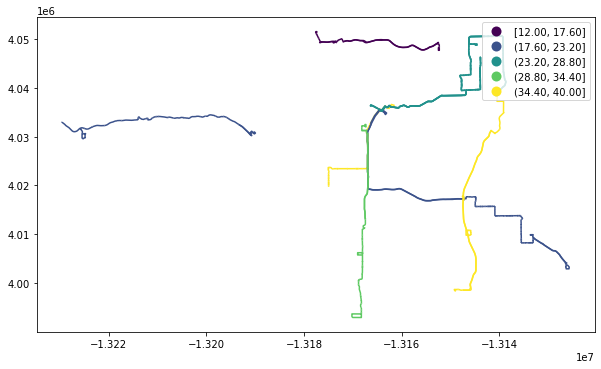

In [20]:
exp_f.plot(
            figsize=(10,10),   
            column = 'ampk_1',  
            legend = True,             
            scheme = 'equal_interval',)   

## Busway Freq

Pulling subset of data- Busway routes

In [21]:
bw_f = bus_freq[bus_freq.tier == 'Busway']
bw_f.sample(3)

,rte,rte2,rteDesc,rteNum,tier,ampk_1,midday_1,pmpk_1,seven_9_10,ten_12_13,...,sa79,sa1012,sa24,su68,su111,su35,su79,su1012,su24,geometry
156,950.0,950,Silver Line,950,Busway,5.0,30.0,5.0,30.0,20.0,...,40.0,20.0,60.0,30.0,30.0,30.0,40.0,20.0,60.0,"MULTILINESTRING ((-13167756.587 3992199.021, -..."
134,910.0,910,Silver Line,910,Busway,5.0,30.0,5.0,30.0,20.0,...,40.0,20.0,60.0,30.0,30.0,30.0,40.0,20.0,60.0,"MULTILINESTRING ((-13167756.587 3992199.021, -..."
133,901.0,901,Orange Line,901,Busway,5.0,10.0,5.0,10.0,20.0,...,15.0,20.0,40.0,12.0,10.0,10.0,15.0,20.0,40.0,"MULTILINESTRING ((-13180086.223 4051450.769, -..."


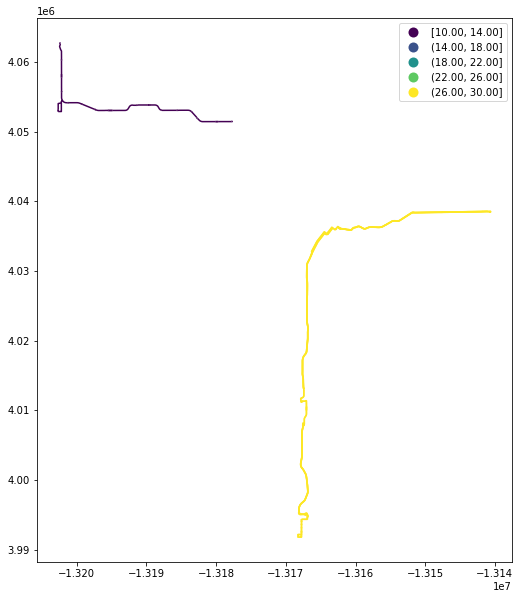

In [22]:
bw_f.plot(
            figsize=(10,10),   
            column = 'midday_1',  
            legend = True,             
            scheme = 'equal_interval',)   

# Rail Line Stations 

Now for some rail lines. Going to do a little exploration. I've done this before during one of our class labs and on my own, but that over a month ago and I'm no longer farmiliar with this dataset.

In [23]:
type(rail_stops)

geopandas.geodataframe.GeoDataFrame

In [24]:
rail_stops.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LINE       83 non-null     object  
 1   LINENUM    83 non-null     int64   
 2   LINENUM2   83 non-null     int64   
 3   STNSEQ     83 non-null     int64   
 4   STNSEQ2    83 non-null     int64   
 5   DIR        3 non-null      object  
 6   STOPNUM    83 non-null     int64   
 7   STATION    83 non-null     object  
 8   LAT        83 non-null     float64 
 9   LONG       83 non-null     float64 
 10  TPIS_NAME  83 non-null     object  
 11  POINT_X    83 non-null     float64 
 12  POINT_Y    83 non-null     float64 
 13  geometry   83 non-null     geometry
dtypes: float64(4), geometry(1), int64(5), object(4)
memory usage: 9.2+ KB


In [25]:
rail_stops.shape

(83, 14)

In [26]:
rail_stops.head(3)

,LINE,LINENUM,LINENUM2,STNSEQ,STNSEQ2,DIR,STOPNUM,STATION,LAT,LONG,TPIS_NAME,POINT_X,POINT_Y,geometry
0,Blue,801,0,21,0,None,80101,Downtown Long Beach Station,33.768071,-118.192921,Long Bch,6.503030e+06,1.738034e+06,POINT (6503030.095 1738033.828)
1,Blue,801,0,22,0,North,80102,Pacific Ave Station,33.772258,-118.193700,Pacific,6.502796e+06,1.739558e+06,POINT (6502796.262 1739558.050)
2,Blue,801,0,18,0,None,80105,Anaheim Street Station,33.781830,-118.189384,Anaheim,6.504115e+06,1.743039e+06,POINT (6504114.567 1743039.068)


How many rail stops are there per line. 

In [27]:
rail_stops['LINE'].value_counts()

Gold          21
Blue          20
Green         14
EXPO          10
Red            8
Red/Purple     6
Blue/EXPO      2
Purple         2
Name: LINE, dtype: int64

This helpful. Though from previous research, I know rail is not heavily used by LA resdients, or used often at all. LA is a car city first, then a bus city. Still, I want to explore the associations with the use of high transit.

Going to map rail line stations.

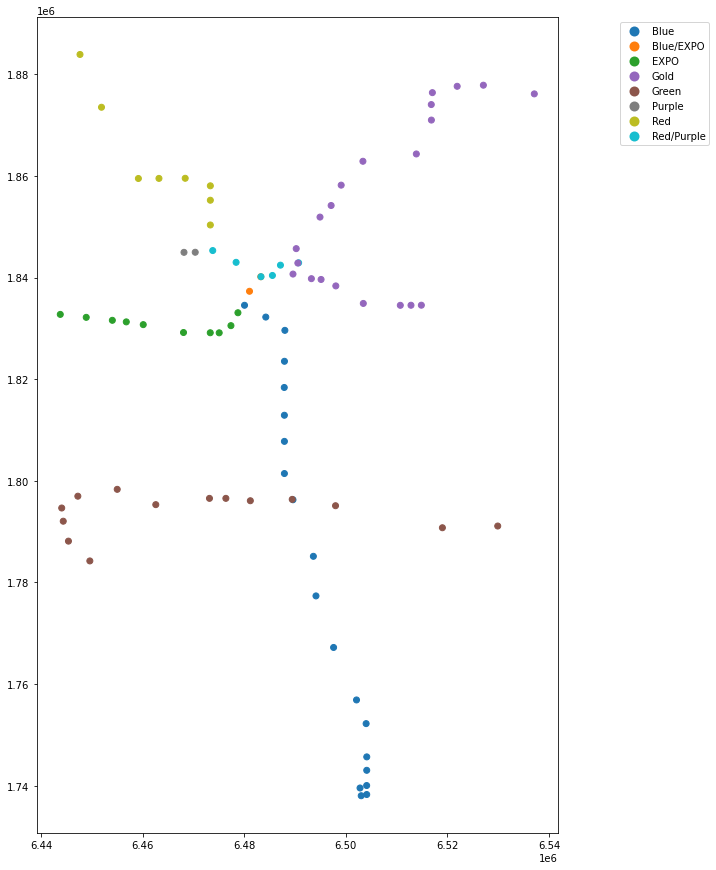

In [28]:
rail_stops.plot(
            figsize=(20,15),   
            column = 'LINE',  
            legend = True,             
            legend_kwds={
               'loc': 'upper right',
               'bbox_to_anchor':(1.3,1)
            }
)

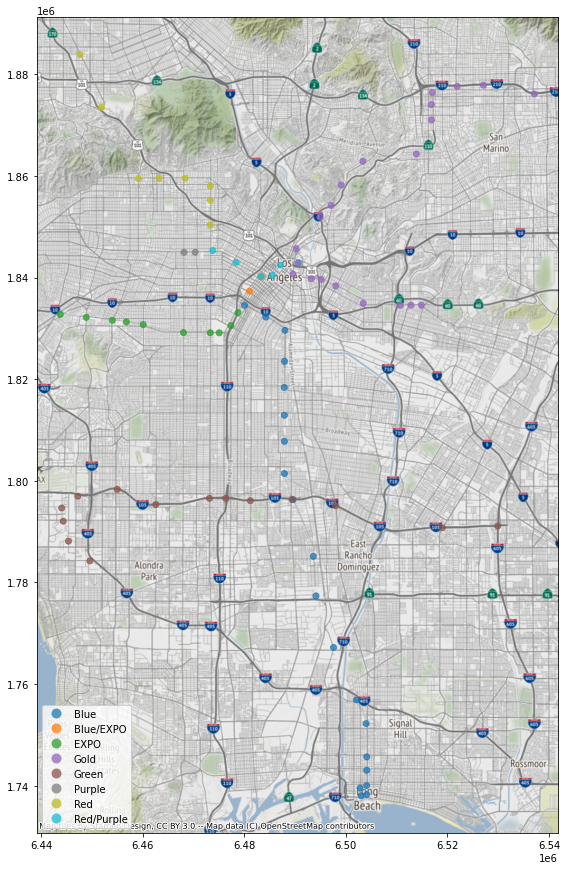

In [29]:
fig, ax = plt.subplots(figsize=(20, 15))

rail_stops.plot(column='LINE', 
            alpha=0.75, 
            ax=ax,
            legend=True
           )
ctx.add_basemap(ax,crs=rail_stops.crs.to_string())

There are more robust options to do here, especially with folium. 